# HPC Benchmarking

A common way to characterize the performance of a high-performance computer (HPC) is to run computational benchmarks.  These standardized tests are typically designed to stress and measure the performance of different features of the HPC hardware.  Generally, there are three different areas that can be tested independently:

1. CPU
2. **Memory**
3. Network

In this tutorial, we'll focus on performing and interpreting a memory-intensive test using the STREAM benchmark.  We'll also attempt to characterize what happens to the performance as we utilize different configurations of the available HPC hardware.

## The STREAM Benchmark

The STREAM benchmark is a straightforward algorithm that tests the speed at which simple operations can be carried out on a very memory-intensive vector.  The four vector operations being iterated are (1) copying, (2) scaling, (3) addition, and (4) a combination of all three, the "triad".

| Operation | Sample                      |  Flops |
|-----------|-----------------------------|--------|
| Copying   | `c[j] = a[j]`               | 0      |
| Scaling   | `b[j] = scalar*c[j]`        | 1      |
| Addition  | `c[j] = a[j] + b[j]`        | 1      |
| Triad     | `a[j] = b[j] + scalar*c[j]` | 2      |

As you can see in the table above, the computational complexity of these operations is quite low.  It's important to reiterate that the STREAM benchmark is primarily focused on testing the effects of a memory-intensive operation, *not* a CPU-intensive calculation.  The end results of the STREAM benchmark aren't actually the four vectors being computed above; instead, the results are the time it takes to execute these simple operations.  The key components of the algorithm and timing steps are printed below.

```C
for (k=0; k<NTIMES; k++) {
    //======== Copying Test ========
    time[0][k] = getTime();
    for (j=0; j<STREAM_ARRAY_SIZE; j++) {
        c[j] = a[j];
    }
    time[0][k] = getTime() - time[0][k];

    //======== Scaling Test ========
    time[1][k] = getTime();
    for (j=0; j<STREAM_ARRAY_SIZE; j++) {
        b[j] = scalar*c[j];
    }
    time[1][k] = getTime() - time[1][k];

    //======== Addition Test ========
    time[2][k] = getTime();
    for (j=0; j<STREAM_ARRAY_SIZE; j++) {
        c[j] = a[j]+b[j];
    }
    time[2][k] = getTime() - time[2][k];

    //======== Triad Test ========
    time[3][k] = getTime();
    for (j=0; j<STREAM_ARRAY_SIZE; j++) {
        a[j] = b[j]+scalar*c[j];
    }
    time[3][k] = getTime() - time[3][k];
}
```

Each of the four operations, copying, scaling, addition, and triad, is carried out a total of `NTIMES`.  Each trial is timed and stored individually.  At the end of the program, the minimum, maximum, and average time required for each of the four operations is presented, along with a measure of the maximum bandwidth achieved.

How big should the value `STREAM_ARRAY_SIZE` be?  STREAM requires different amounts of memory to run on different systems, depending on both the system cache size(s) and the granularity of the system timer.  Practically speaking, the size must be large enough to "stress" the system.  This means: (1) Each array must be at least 4 times the size of the available cache memory, and (2) the size should be large enough so that the "timing calibration" output by the program is at least 20 clock-ticks.

<br/>

<div class="alert alert-block alert-info">
<b>What about multi-core?</b>  For simplicity, the OpenMP commands that parallelize the <code>for</code> loops have been omitted from the example code shown above.  The actual source code in <code>stream.c</code> includes all directives for compiling a parallel version of the STREAM benchmark, and can be run on different configurations of cores as shown in the following examples.
</div>

## Compiling STREAM

To begin, copy the entire `stream_benchmark` directory to your HPC account (Don't have an account? __[Get one here.](https://www.nrel.gov/hpc/user-accounts.html)__).  Once the copying step is finished, navigate to the `stream_benchmark` folder and execute the following compilation commands

`module purge`

`module load intel-mpi`

`icc -o stream_omp -qopenmp stream.c`

In the first line, we purge any previously-loaded modules to ensure this test starts with a blank slate.  In the second line, we load the Intel compiler we'll be using to create the stream executable.  In the third line, we compile the code using the Intel compiler (icc) which creates an executable, `stream_omp`, from the code contained in `stream.c` to run in parallel using OpenMP.

## Running the benchmark

To run the example, first obtain an interactive debugging node on Eagle (`srun -A <project_allocation> -t <time> --pty $SHELL` so that the actual benchmark isn't being run on one of the login nodes), then execute the following two-part command

`export OMP_NUM_THREADS=1; ./stream_omp`

which first sets the number of OpenMP threads to 1 and then immediately runs the compiled STREAM benchmark.  After the code has finished running, you will see something similar to the output below.

```
-------------------------------------------------------------
STREAM version $Revision: 5.10 $
-------------------------------------------------------------
This system uses 8 bytes per array element.
-------------------------------------------------------------
Array size = 50000000 (elements), Offset = 0 (elements)
Memory per array = 381.5 MiB (= 0.4 GiB).
Total memory required = 1144.4 MiB (= 1.1 GiB).
Each kernel will be executed 10 times.
 The *best* time for each kernel (excluding the first iteration)
 will be used to compute the reported bandwidth.
-------------------------------------------------------------
Number of Threads requested = 1
Number of Threads counted = 1
-------------------------------------------------------------
Your clock granularity/precision appears to be 1 microseconds.
Each test below will take on the order of 33384 microseconds.
   (= 33384 clock ticks)
Increase the size of the arrays if this shows that
you are not getting at least 20 clock ticks per test.
-------------------------------------------------------------
WARNING -- The above is only a rough guideline.
For best results, please be sure you know the
precision of your system timer.
-------------------------------------------------------------
Function    Best Rate MB/s  Avg time     Min time     Max time
Copy:           10620.1     0.075546     0.075329     0.075791
Scale:          10782.8     0.074321     0.074192     0.074569
Add:            13800.5     0.087064     0.086953     0.087326
Triad:          13853.6     0.086753     0.086620     0.086986
-------------------------------------------------------------
Solution Validates: avg error less than 1.000000e-13 on all three arrays
-------------------------------------------------------------
```

Looking through the output, we see that this benchmark ran with $50\times10^6$ elements of type `double` in each vector.  Each test was carried out 10 times using only the single (1) requested thread.  The average, minimum, and maximum execution times for each test are tabulated near the bottom of the output.
 
 <br/>
 
<div class="alert alert-block alert-info">
<b>Adjusting <code>STREAM_ARRAY_SIZE</code></b>  If your results indicate that the size of the array was too small, i.e., clock ticks $<20$, you'll need to manually increase the size of the arrays being tested by directly editing the <code>stream.c</code> file on line <code>#define STREAM_ARRAY_SIZE  50000000</code>.  Change the value assigned to <code>STREAM_ARRAY_SIZE</code> at the beginning of the algorithm to something like $60\times10^6$, re-compile the code, and re-run the benchmark.
</div>

## Scalability

What does this test tell us?  Taken alone, not much.  What we'd like to know now is how the performance scales as the number of tasks is increased.  What happens if instead of tackling this problem with a single core, we divide the work amongst 4 cores? Or 8? Or 32?  Surely the smaller we make each individual sub-problem, the faster the overall solution can be calculated.  The results below were generated to test this hypothesis. 


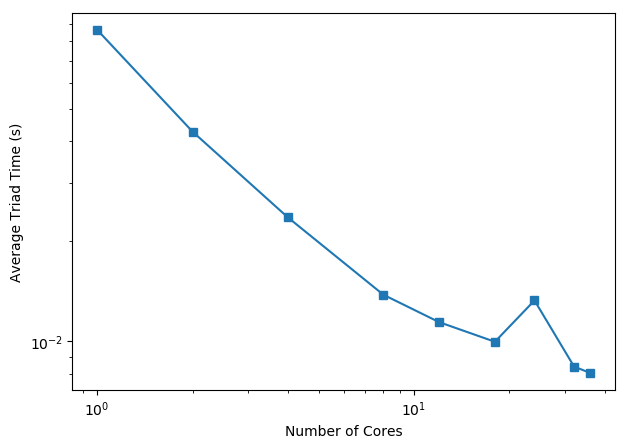

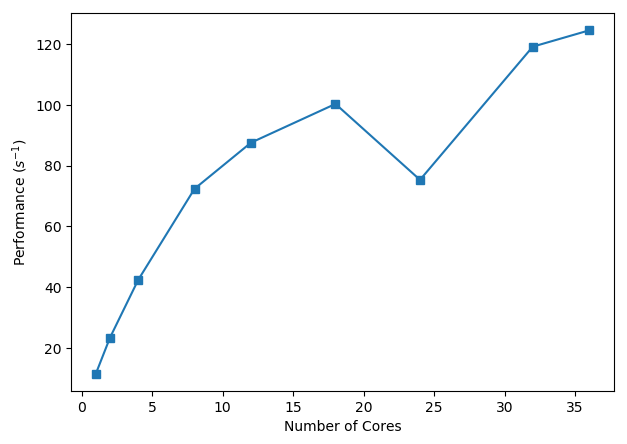

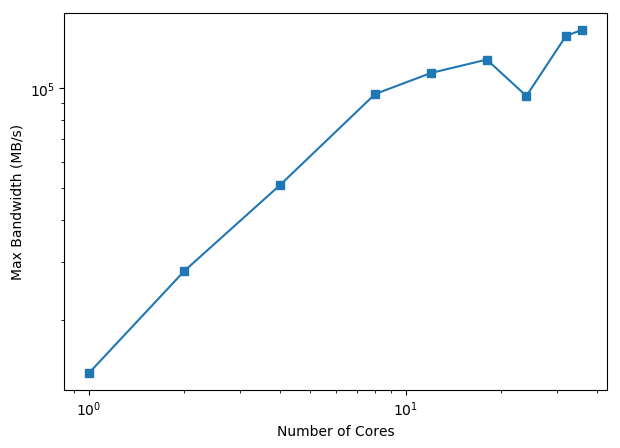

In [5]:
%reset -f
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import the data for all runs stored as a .CSV file
pin_none = pd.read_csv("stream_results_icc/pin_none.csv", sep='\s*,\s*', header=0, engine='python')

# Plot the average triad time vs number of cores
plt.figure(figsize=(7, 5), dpi=100)
fig = plt.loglog(pin_none["Cores"], pin_none["Avg"], '-s')
plt.xlabel("Number of Cores")
plt.ylabel("Average Triad Time (s)")
plt.show()

# Plot the performance (1/average triad time) vs number of cores
plt.figure(figsize=(7, 5), dpi=100)
fig = plt.plot(pin_none["Cores"], 1/pin_none["Avg"], '-s')
plt.xlabel("Number of Cores")
plt.ylabel("Performance ($s^{-1}$)")
plt.show()

# Plot the maximum bandwidth vs number of cores
plt.figure(figsize=(7, 5), dpi=100)
fig = plt.loglog(pin_none["Cores"], pin_none["Bandwidth"], '-s')
plt.xlabel("Number of Cores")
plt.ylabel("Max Bandwidth (MB/s)")
plt.show()


As it turns out, the actual performance curve is slightly more complicated than categorically saying, "More cores is better".  As shown in the plot above, the improvement trend only continues up to a certain point.  Past this threshold, we reach the point of diminishing returns where adding more cores doesn't result in dramatically faster run time and may actually result in *decreased* performance.

## Effects of Thread Binding

In the previous test, we increased the number of cores to distribute the vector workload, but didn't say anything about *how* the work should be divided.  We can set additional OpenMP options to more tightly control how the threads move around the total number of computational resources being requested with the `OMP_NUM_THREADS` option.  Simply prefix either of the following two options to our two-part run command.

`export OMP_PLACES=cores; ...`

`export OMP_PLACES=sockets; ...`

Respectively, these optional declarations ensure that threads are bound to specific cores or to specific sockets (and in this latter case, can shuffle between cores on the same socket).  The triad timing results for a $50\times 10^6$ element vector averaged over 10 trials are summarized below.  Additionally, we can look at how the compiler itself affects this behavior.  Our original testing was done with the Intel compiler (`icc -o stream -qopenmp stream.c`) but the code can be compiled using the Gnu compiler using the command `gcc -o stream_gcc -fopenmp stream.c` (Note: the distinction between `fopenmp` vs `qopenmp` and that the gcc compiler doesn't require loading any modules prior to the compilation step).

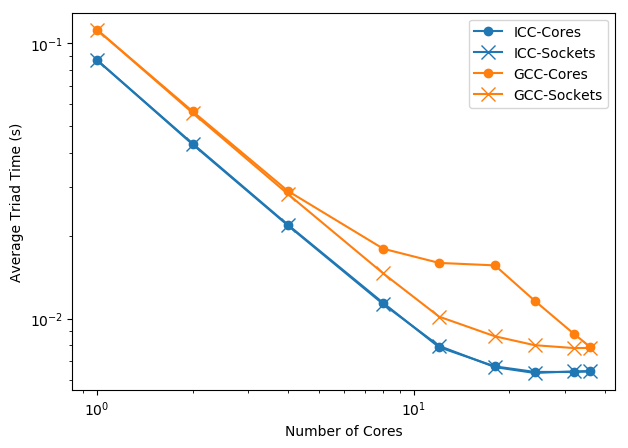

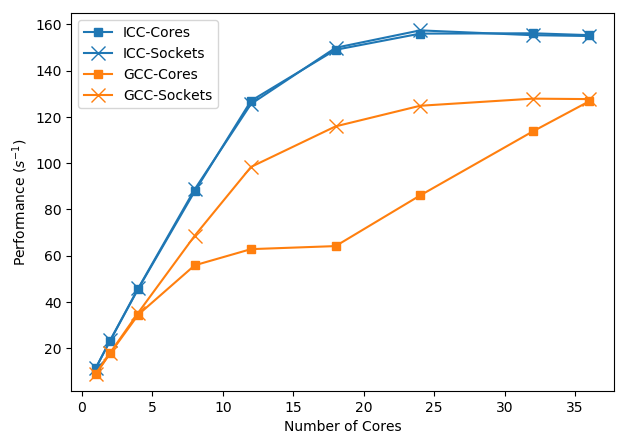

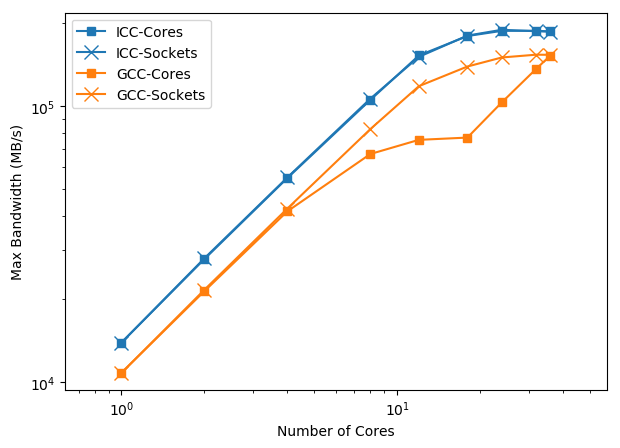

In [6]:
%reset -f
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import the data for all runs stored as a .CSV file
pin_cores = pd.read_csv("stream_results_icc/pin_cores.csv", sep='\s*,\s*', header=0, engine='python')
pin_sockets = pd.read_csv("stream_results_icc/pin_sockets.csv", sep='\s*,\s*', header=0, engine='python')
pin_cores_gcc = pd.read_csv("stream_results_gcc/pin_cores.csv", sep='\s*,\s*', header=0, engine='python')
pin_sockets_gcc = pd.read_csv("stream_results_gcc/pin_sockets.csv", sep='\s*,\s*', header=0, engine='python')

# Plot the average triad time vs number of cores
plt.figure(figsize=(7, 5), dpi=100)
fig = plt.loglog(pin_cores["Cores"], pin_cores["Avg"], 'o-', color="C0")
plt.loglog(pin_sockets["Cores"], pin_sockets["Avg"], '-x', color="C0", markersize=10)
plt.loglog(pin_cores_gcc["Cores"], pin_cores_gcc["Avg"], 'o-', color="C1")
plt.loglog(pin_sockets_gcc["Cores"], pin_sockets_gcc["Avg"], '-x', color="C1", markersize=10)
plt.xlabel("Number of Cores")
plt.ylabel("Average Triad Time (s)")
plt.legend(("ICC-Cores", "ICC-Sockets", "GCC-Cores", "GCC-Sockets"))
plt.show()

# Plot the performance (1/average triad time) vs number of cores
plt.figure(figsize=(7, 5), dpi=100)
fig = plt.plot(pin_cores["Cores"], 1/pin_cores["Avg"], 's-', color="C0")
plt.plot(pin_sockets["Cores"], 1/pin_sockets["Avg"], '-x', color="C0", markersize=10)
plt.plot(pin_cores_gcc["Cores"], 1/pin_cores_gcc["Avg"], 's-', color="C1")
plt.plot(pin_sockets_gcc["Cores"], 1/pin_sockets_gcc["Avg"], '-x', color="C1", markersize=10)
plt.xlabel("Number of Cores")
plt.ylabel("Performance ($s^{-1}$)")
plt.legend(("ICC-Cores", "ICC-Sockets", "GCC-Cores", "GCC-Sockets"))
plt.show()

# Plot the maximum bandwidth vs number of cores
plt.figure(figsize=(7, 5), dpi=100)
fig = plt.loglog(pin_cores["Cores"], pin_cores["Bandwidth"], 's-', color="C0")
plt.loglog(pin_sockets["Cores"], pin_sockets["Bandwidth"], '-x', color="C0", markersize=10)
plt.loglog(pin_cores_gcc["Cores"], pin_cores_gcc["Bandwidth"], 's-', color="C1")
plt.loglog(pin_sockets_gcc["Cores"], pin_sockets_gcc["Bandwidth"], '-x', color="C1", markersize=10)
plt.axis('equal')
plt.xlabel("Number of Cores")
plt.ylabel("Max Bandwidth (MB/s)")
plt.legend(("ICC-Cores", "ICC-Sockets", "GCC-Cores", "GCC-Sockets"))
plt.show()


## Interpretation

When studying these results, the first thing that becomes apparant is that, on the whole, the Intel compiler has a performance edge over the Gnu compiler for this particular piece of code.  Second, there's a fundamental difference in the way the two compilers distribute the number of total number of tasks amongst the available computing cores.  The Intel compiler attempts to "spread" the distribution of tasks between the two different compute sockets.  For example, task 0 goes to the first core on socket 0, task 1 goes to the first core on socket 1, task 2 goes to the second core on socket 0, and so on, keeping the workload between the two sockets roughly equal.  This is very similar to how `OMP_PLACES=sockets` distributes threads, and so we see very close matching between the two performance curves.  In contrast, the Gnu compiler assigns task 0 to the first core on socket 0, task 1 to the second core on socket 0, task 2 to the third core on socket 0, and so on until socket 0 is full, then moves on to filling the second socket.  Without any sort of balancing behavior, you can see the effect of the "saturation" of the first socket in the performance curves, with numbers of cores $<=18$ (the number of cores on a single socket) reaching a plateau, then continuing to increase for numbers of cores $>18$ as the new socket is opened up.